# Architectures with Mel Spectrogram as Input
## Audio Classification with the NBAC dataset

This notebook performs audio classification on audio fragments of 5 seconds long

In [2]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import IPython.display as ipd
import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.models import Sequential

## Load the data

### NBAC Dataset

In [3]:
# Determine the Sample Rate to load the audio files

SR = 16000

In [4]:
!git clone https://github.com/DavidCastello/NBAC.git

Cloning into 'NBAC'...
remote: Enumerating objects: 734, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 734 (delta 2), reused 86 (delta 2), pack-reused 647
Receiving objects: 100% (734/734), 443.54 MiB | 27.69 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (723/723), done.


In [5]:
def map_subfolders_to_int(path):
    reversed_labels = {}
    counter = 0

    # Walk through the directory
    for root, dirs, files in os.walk(path):
        # For each subdirectory
        for dir in dirs:
            # Add the subdirectory to the dictionary with the current count as the key
            reversed_labels[counter] = dir
            counter += 1

    return reversed_labels

# Specify your directory path here
directory_path = "/kaggle/working/NBAC/audio"
reversed_labels = map_subfolders_to_int(directory_path)
print(reversed_labels)

{0: 'dog bark', 1: 'talking', 2: 'sneezing', 3: 'traffic', 4: 'snoring', 5: 'coughing', 6: 'silence', 7: 'bed movement', 8: 'siren', 9: 'wind', 10: 'rain', 11: 'loud breathing'}


In [55]:
NUM_CLASSES = len(reversed_labels)

In [28]:
def reverse_dict(original_dict):
    reversed_dict = {value: key for key, value in original_dict.items()}
    return reversed_dict

# reversed dictionary
labels_dict = reverse_dict(reversed_labels)
print(labels_dict)

{'dog bark': 0, 'talking': 1, 'sneezing': 2, 'traffic': 3, 'snoring': 4, 'coughing': 5, 'silence': 6, 'bed movement': 7, 'siren': 8, 'wind': 9, 'rain': 10, 'loud breathing': 11}


### Load the wav files

The data loader `wav_data_loader()` runs normalization with librosa's integrated util: https://librosa.org/doc/main/generated/librosa.util.normalize.html

Normalization can be disabled if later audio processing techniques apply normalization. In the code of this project, normalization is integrated in the `tf_mel_spectrogram()` function.

`wav_data_loader()` loads the wav files with their corresponding labels as a tuple.

In [6]:
NBAC_FOLDER = '/kaggle/working/NBAC/audio'

In [32]:
def wav_data_loader(directory, sr=SR, normalization=True):
    all_fragments = []
    for root, dirs, _ in os.walk(directory):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
            for file in files:
                file_path = os.path.join(dir_path, file)
                # Load the audio file
                sample, sample_rate = librosa.load(file_path, sr=sr)
                if normalization:
                    # Normalize the waveform
                    sample = librosa.util.normalize(sample)
                # Append the sample and its label (subfolder name) as a tuple
                all_fragments.append((sample, labels_dict[dir]))
    return all_fragments

In [33]:
%%time
nbac_wav_dataset = wav_data_loader(NBAC_FOLDER, normalization=False)
len(nbac_wav_dataset)

CPU times: user 5.65 s, sys: 411 ms, total: 6.07 s
Wall time: 6.08 s


720

## Train-test split

Creating a first train-test split in the original dataset will be useful for correct data augmentation and pre-processing techniques.

In [36]:
X = [wav[0] for wav in nbac_wav_dataset]
y = [wav[1] for wav in nbac_wav_dataset]

X_train_wav, X_test_wav, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_wav, X_val_wav, y_train, y_val = train_test_split(X_train_wav, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Waveform augmentation

In [37]:
## Noise addition

def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

In [38]:
len(X_train_wav)

403

In [39]:
%%time
''' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION
Lots of memory required this step could be optimized'''

def augment_wavs(wav_dataset, y):
    
    wav_dataset_augmented = []

    for wav in wav_dataset:
        # Create a copy of the original wav to prevent unwanted side effects
        temp_wav = wav.copy()
        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04
        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%
        temp_wav = time_stretching(temp_wav, 0.85)

        wav_dataset_augmented.append(temp_wav)

    # Add original wavs to augmented list
    wav_dataset_augmented.extend(wav_dataset)
    
    y = y + y #each spec is being appended at the bottom of the list

    return wav_dataset_augmented, y

X_train_wav, y_train = augment_wavs(X_train_wav, y_train)

CPU times: user 23 s, sys: 42.5 ms, total: 23 s
Wall time: 23.3 s


In [40]:
len(X_train_wav)

806

In [42]:
len(y_train)

806

## Mel Spectrogram Generator

In [43]:
def tf_mel_spectrogram(wav, sample_rate=SR, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001):
    
    # Convert numpy array to Tensor and normalize based on its actual max and min values
    wav = tf.cast(wav, tf.float32)
    audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1

    # Calculate the frame_length and frame_step based on window size and hop size
    frame_length = int(sample_rate * 0.025)  # 25 ms window
    frame_step = int(sample_rate * 0.01)  # 10 ms hop

    # Calculate the spectrogram
    spectrogram = tf.signal.stft(audio_tensor, frame_length=frame_length, frame_step=frame_step, window_fn=tf.signal.hann_window)

    # Calculate the magnitude of the spectrogram
    magnitude_spectrogram = tf.abs(spectrogram)

    # Define the parameters for the Mel scale
    num_spectrogram_bins = magnitude_spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_freq, upper_freq)

    # Convert the spectrogram to the Mel scale
    mel_spectrogram = tf.tensordot(magnitude_spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(magnitude_spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Apply a logarithmic scale
    log_mel_spectrogram = tf.math.log(mel_spectrogram + log_offset)

    return log_mel_spectrogram.numpy()

In [44]:
%%time

X_train_specs = []

X_train_specs = list(map(lambda x: tf_mel_spectrogram(x), X_train_wav))

X_val_specs = []

X_val_specs = list(map(lambda x: tf_mel_spectrogram(x), X_val_wav))

X_test_specs = []

X_test_specs = list(map(lambda x: tf_mel_spectrogram(x), X_test_wav))

CPU times: user 32.8 s, sys: 1.71 s, total: 34.5 s
Wall time: 32.5 s


In [45]:
len(X_train_specs)

806

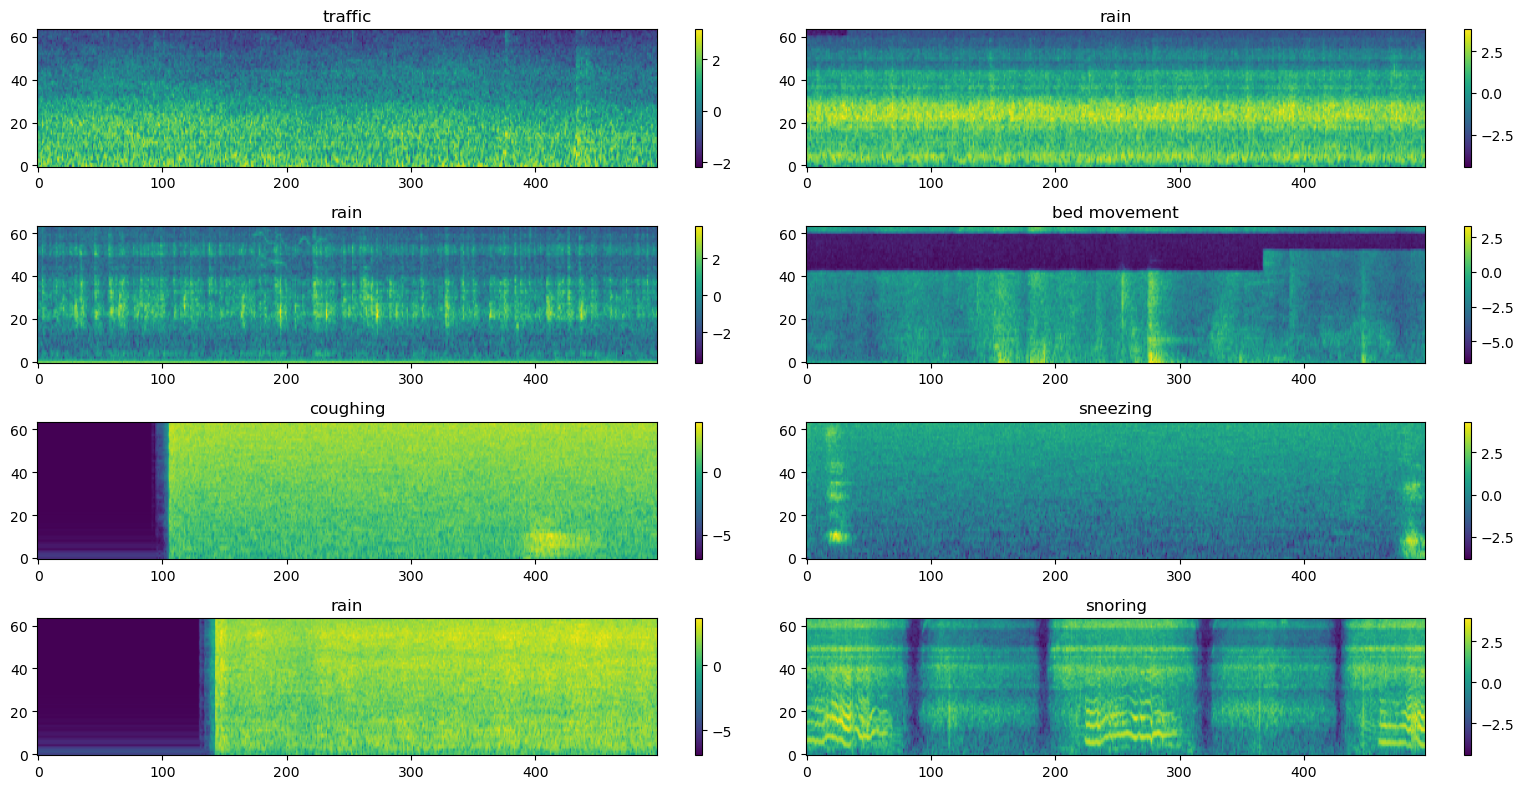

In [47]:
# View 8 random spectrograms
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

# Generate 8 random indices
indices = np.random.choice(len(y_train), size=8, replace=False)

for i, ax in enumerate(axs.ravel()):
    idx = indices[i]  # use the randomly generated index
    ax.set_title(reversed_labels[y_train[idx]])
    spectrogram = X_train_specs[idx].T  # Transpose the spectrogram
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Spectrogram augmentation

In [48]:
# SPECTROGRAM AUGMENTATION

def frequency_mask(spectrogram, p):
    """
    Mask out two percentages of frequencies from the spectrogram.
    """

    # Generate two random start and end points for the masks
    start1 = random.randint(0, spectrogram.shape[0] - 1)
    end1 = min(start1 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    start2 = random.randint(0, spectrogram.shape[0] - 1)
    end2 = min(start2 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    # If masks are overlapping, adjust the second mask
    while start1 <= end2 and end1 >= start2:
        start2 = random.randint(0, spectrogram.shape[0] - 1)
        end2 = min(start2 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    # Create a mask with the same shape as the spectrogram
    mask = np.ones(spectrogram.shape)

    # Set the mask values to zero within the specified range of frequencies
    mask[start1:end1, :] = 0
    mask[start2:end2, :] = 0

    # Apply the mask to the spectrogram
    masked_spectrogram = spectrogram * mask

    return masked_spectrogram

def time_mask(spectrogram, p):
    """
    Mask out two percentages of time from the spectrogram.
    """

    # Generate two random start and end points for the masks
    start1 = random.randint(0, spectrogram.shape[1] - 1)
    end1 = min(start1 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    start2 = random.randint(0, spectrogram.shape[1] - 1)
    end2 = min(start2 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    # If masks are overlapping, adjust the second mask
    while start1 <= end2 and end1 >= start2:
        start2 = random.randint(0, spectrogram.shape[1] - 1)
        end2 = min(start2 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    # Create a mask with the same shape as the spectrogram
    mask = np.ones(spectrogram.shape)

    # Set the mask values to zero within the specified range of time
    mask[:, start1:end1] = 0
    mask[:, start2:end2] = 0

    # Apply the mask to the spectrogram
    masked_spectrogram = spectrogram * mask

    return masked_spectrogram

In [49]:
def augment_spectrograms(X_specs, y):
    
    X_specs_augmented = []

    for spec in X_specs:
        
        # Apply frequency and time masking
        augmented_spectrogram = frequency_mask(spec, 0.15)  # change 'p' as needed
        augmented_spectrogram = time_mask(augmented_spectrogram, 0.1)  # change 'p' as needed

        X_specs_augmented.append(augmented_spectrogram)

    X_specs = X_specs + X_specs_augmented

    y = y + y
    
    return X_specs, y

In [50]:
X_train_specs, y_train = augment_spectrograms(X_train_specs, y_train)

In [51]:
len(X_train_specs)

1612

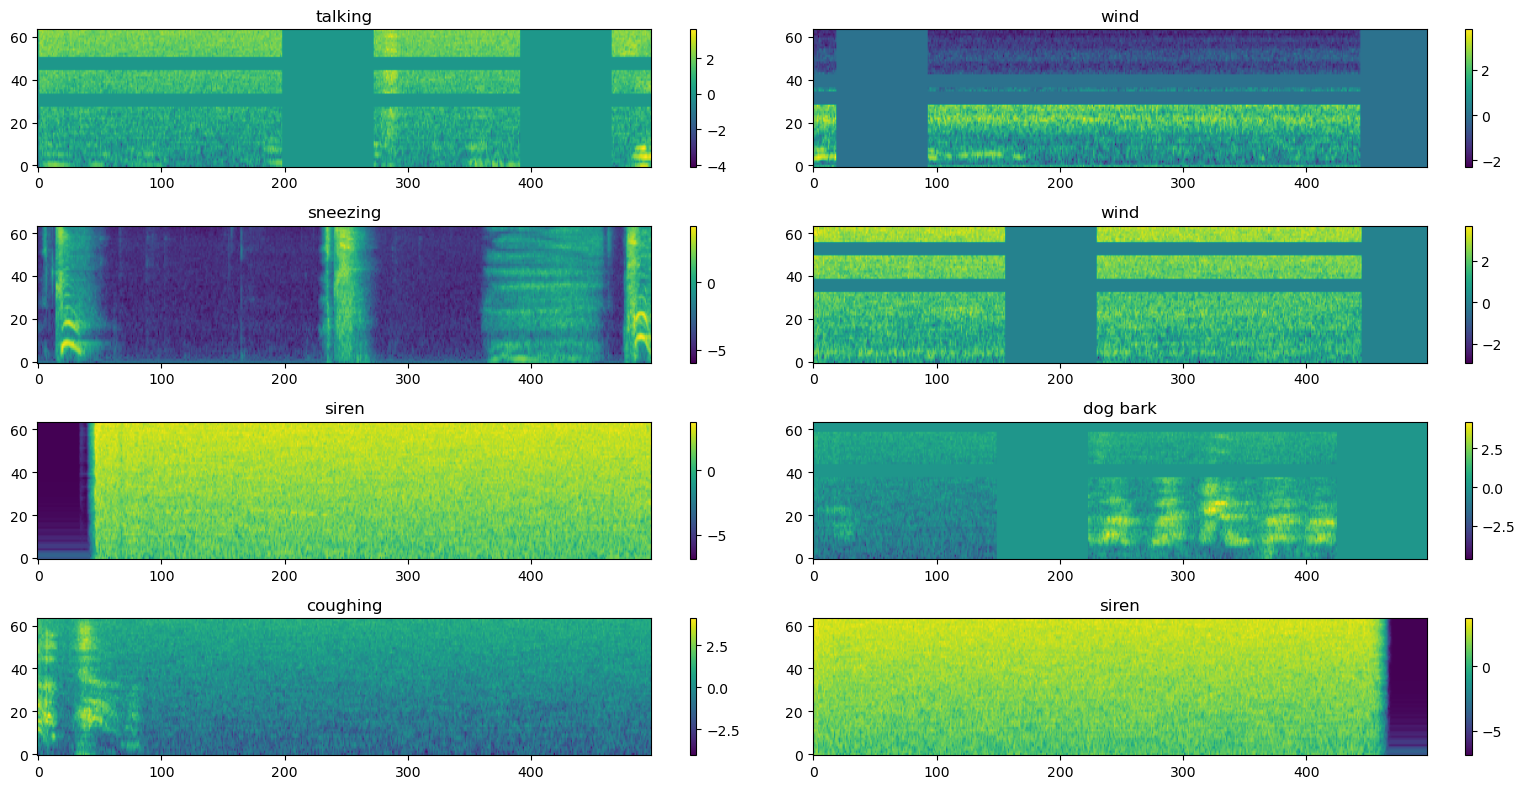

In [52]:
# View 8 random spectrograms
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

# Generate 8 random indices
indices = np.random.choice(len(y_train), size=8, replace=False)

for i, ax in enumerate(axs.ravel()):
    idx = indices[i]  # use the randomly generated index
    ax.set_title(reversed_labels[y_train[idx]])
    spectrogram = X_train_specs[idx].T  # Transpose the spectrogram
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

# Training

In [53]:
X_train_specs = tf.expand_dims(X_train_specs, -1)  # add a channel dimension
X_val_specs = tf.expand_dims(X_val_specs, -1)  # add a channel dimension
X_test_specs = tf.expand_dims(X_test_specs, -1)  # add a channel dimension

## Basic CNN Architecture

In [56]:
HLF = Sequential([
    tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])

Embeddings = Sequential([
    tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_specs), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_specs), np.array(y_val)))

Epoch 1/50


2023-06-17 15:36:21.246644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/sequential_3/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


51/51 [==============================] - 14s 31ms/step - loss: 2.2584 - accuracy: 0.2221 - val_loss: 2.2057 - val_accuracy: 0.3168
Epoch 2/50
51/51 [==============================] - 1s 19ms/step - loss: 1.8513 - accuracy: 0.3722 - val_loss: 1.8280 - val_accuracy: 0.4554
Epoch 3/50
51/51 [==============================] - 1s 19ms/step - loss: 1.6414 - accuracy: 0.4429 - val_loss: 1.4747 - val_accuracy: 0.5149
Epoch 4/50
51/51 [==============================] - 1s 19ms/step - loss: 1.4950 - accuracy: 0.4870 - val_loss: 1.3641 - val_accuracy: 0.5446
Epoch 5/50
51/51 [==============================] - 1s 18ms/step - loss: 1.3212 - accuracy: 0.5577 - val_loss: 1.2448 - val_accuracy: 0.5743
Epoch 6/50
51/51 [==============================] - 1s 19ms/step - loss: 1.2192 - accuracy: 0.5881 - val_loss: 1.2724 - val_accuracy: 0.6040
Epoch 7/50
51/51 [==============================] - 1s 20ms/step - loss: 1.1113 - accuracy: 0.6303 - val_loss: 1.4694 - val_accuracy: 0.5050
Epoch 8/50
51/51 [=====

In [57]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_specs), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

7/7 - 0s - loss: 1.2748 - accuracy: 0.7546 - 226ms/epoch - 32ms/step
Test loss: 1.2748113870620728
Test accuracy: 0.7546296119689941


In [58]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 129676


In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 31, 4, 128)        93568     
                                                                 
 sequential_3 (Sequential)   (None, 256)               33024     
                                                                 
 dense (Dense)               (None, 12)                3084      
                                                                 
 activation (Activation)     (None, 12)                0         
                                                                 
Total params: 129,676
Trainable params: 129,228
Non-trainable params: 448
_________________________________________________________________


### Visualization of the training process

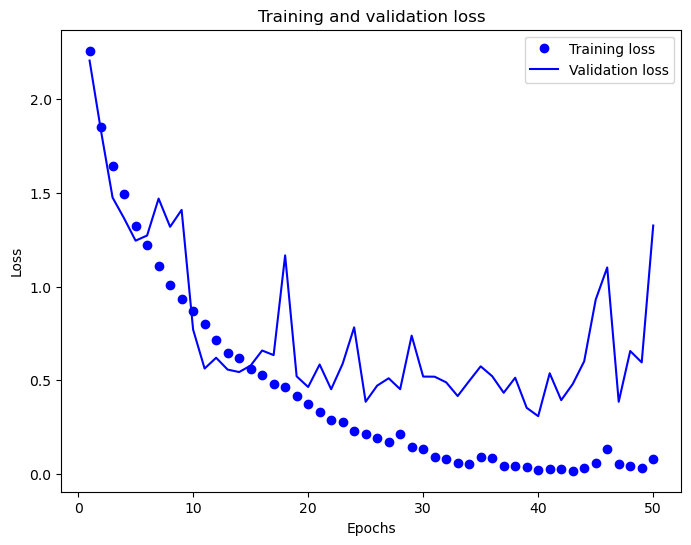

In [60]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

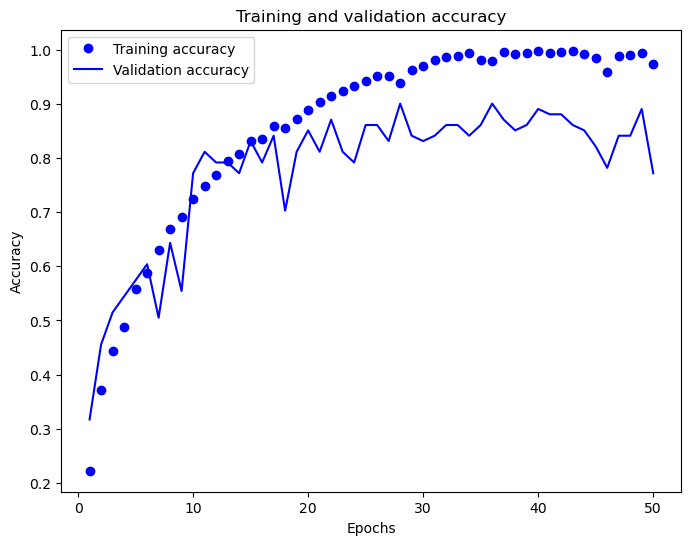

In [61]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
# Save and export the model

model.save('model_nbac_al5s_basic.h5')

In [63]:
# Save arrays to a file
np.savez('checkpoint_2.npz', X_train_specs=X_train_specs, X_val_specs=X_val_specs, X_test_specs=X_test_specs, y_train=y_train, y_val=y_val, y_test=y_test, reversed_labels=reversed_labels)

### Confusion matrix

7/7 [==============================] - 0s 5ms/step


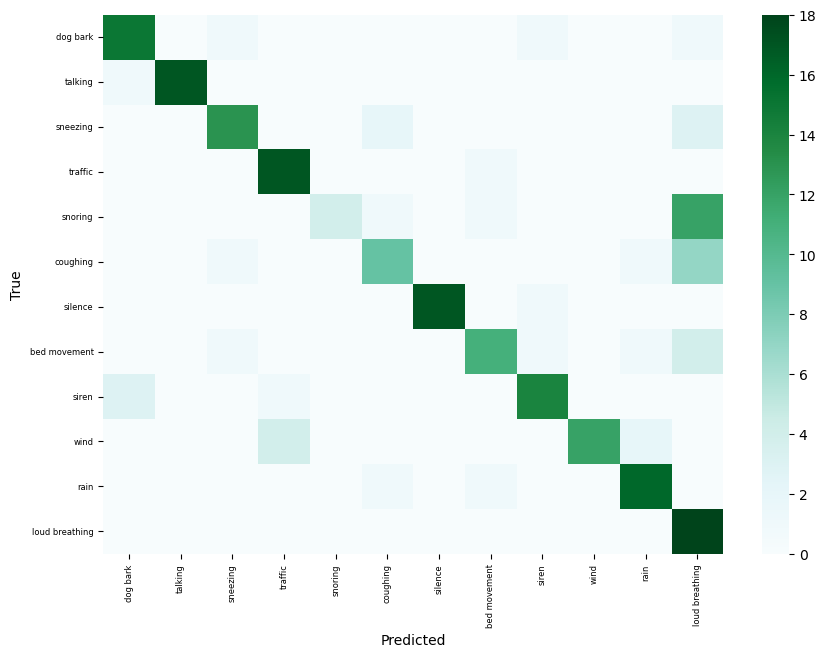

In [64]:
y_true = y_test
y_pred = model.predict(X_test_specs)
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Depth Wise Separable Convolutions

In [65]:
HLF = Sequential([
    tf.keras.layers.SeparableConv2D(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])

Embeddings = Sequential([
    tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_specs), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_specs), np.array(y_val)))

Epoch 1/50


2023-06-17 15:39:39.113812: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/sequential_6/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


51/51 [==============================] - 5s 30ms/step - loss: 2.2135 - accuracy: 0.2438 - val_loss: 2.4695 - val_accuracy: 0.1485
Epoch 2/50
51/51 [==============================] - 1s 19ms/step - loss: 1.8712 - accuracy: 0.3573 - val_loss: 2.4551 - val_accuracy: 0.1881
Epoch 3/50
51/51 [==============================] - 1s 19ms/step - loss: 1.7158 - accuracy: 0.4107 - val_loss: 2.4256 - val_accuracy: 0.2277
Epoch 4/50
51/51 [==============================] - 1s 19ms/step - loss: 1.5813 - accuracy: 0.4560 - val_loss: 2.3607 - val_accuracy: 0.2079
Epoch 5/50
51/51 [==============================] - 1s 18ms/step - loss: 1.4723 - accuracy: 0.5105 - val_loss: 2.2565 - val_accuracy: 0.3465
Epoch 6/50
51/51 [==============================] - 1s 21ms/step - loss: 1.4073 - accuracy: 0.5329 - val_loss: 2.0839 - val_accuracy: 0.3663
Epoch 7/50
51/51 [==============================] - 1s 20ms/step - loss: 1.3085 - accuracy: 0.5527 - val_loss: 1.8771 - val_accuracy: 0.4356
Epoch 8/50
51/51 [======

In [66]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_specs), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

7/7 - 0s - loss: 0.5841 - accuracy: 0.8657 - 190ms/epoch - 27ms/step
Test loss: 0.5840945839881897
Test accuracy: 0.8657407164573669


In [67]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 48373


In [68]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 31, 4, 128)        12265     
                                                                 
 sequential_6 (Sequential)   (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
Total params: 48,373
Trainable params: 47,925
Non-trainable params: 448
_________________________________________________________________


### Visualization of the training process

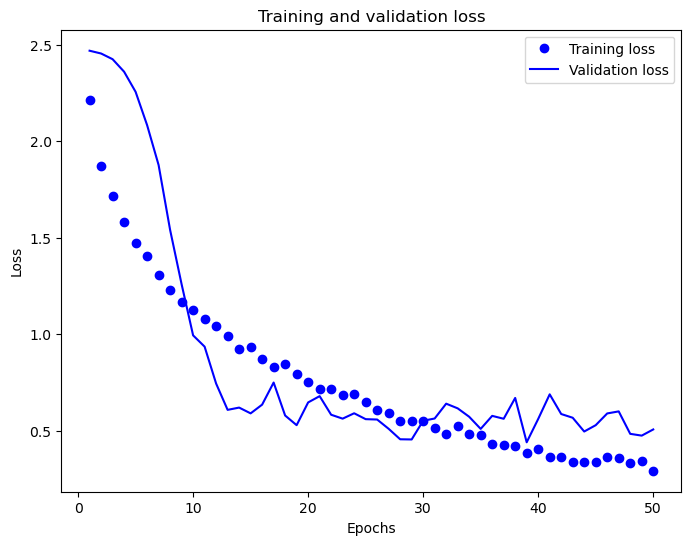

In [69]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

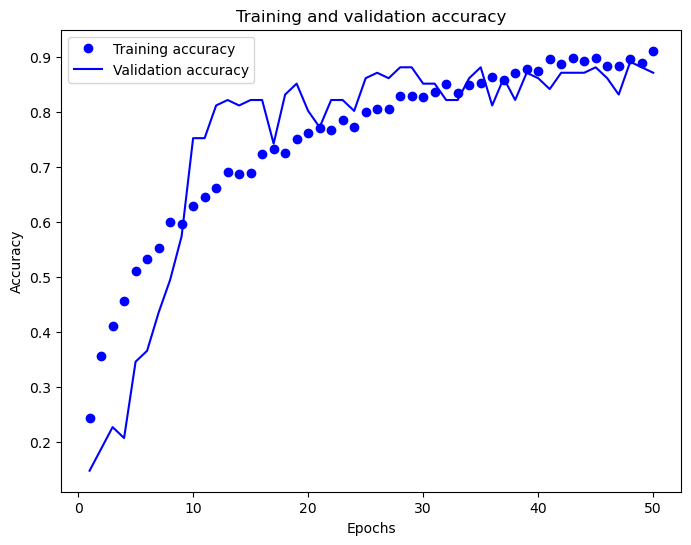

In [70]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [71]:
# Save and export the model

model.save('model_nbac_al5s_dw.h5')

### Confusion matrix

7/7 [==============================] - 0s 6ms/step


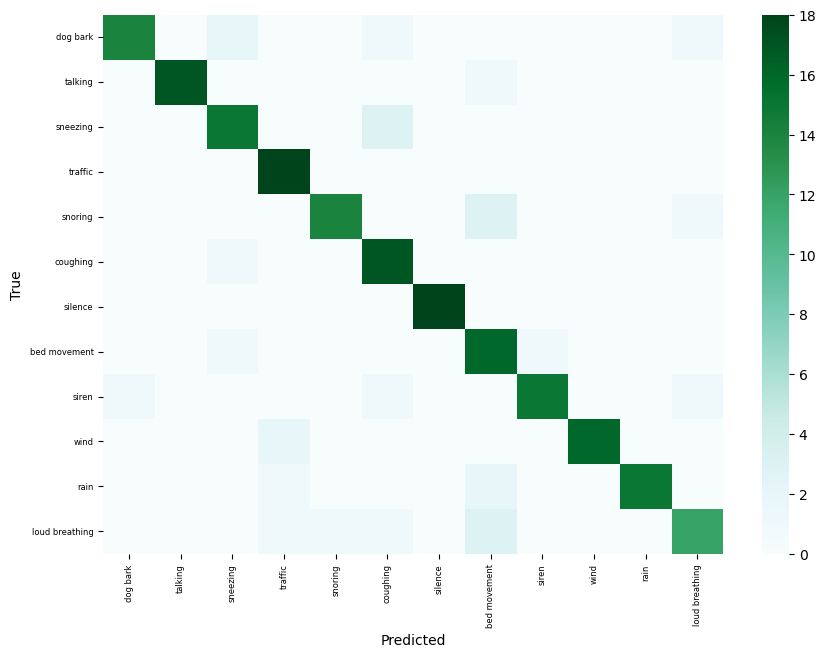

In [73]:
y_true = y_test
y_pred = model.predict(X_test_specs)
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()